
# Weather Prediction With Machine Learning


### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Process Data

In [ ]:
original = pd.read_csv('seattle-weather.csv')
original.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


### Process Data and One Hot Encoding

In [ ]:
data = original.drop('date', axis=1)

# One-hot encode the 'weather' column
weather_encoded = pd.get_dummies(data['weather'], prefix='weather')
data = pd.concat([data, weather_encoded], axis=1)

# Drop the original 'weather' column
data = data.drop('weather', axis=1)
print(data.head(5)) # this is how the dataset currently look like

# Scale numerical features to hopefully get better average result
scaler = StandardScaler()
numerical_features = ['precipitation', 'temp_max', 'temp_min', 'wind']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

   precipitation  temp_max  temp_min  wind  weather_drizzle  weather_fog  \
0            0.0      12.8       5.0   4.7             True        False   
1           10.9      10.6       2.8   4.5            False        False   
2            0.8      11.7       7.2   2.3            False        False   
3           20.3      12.2       5.6   4.7            False        False   
4            1.3       8.9       2.8   6.1            False        False   

   weather_rain  weather_snow  weather_sun  
0         False         False        False  
1          True         False        False  
2          True         False        False  
3          True         False        False  
4          True         False        False  


### Split Into Test and Train Dataloaders

In [ ]:
# Split data
X = data.drop(list(weather_encoded.columns), axis=1) #Exclude weather
y = data[list(weather_encoded.columns)] #Predict all weather
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create train and test loaders
batch_size = 20
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class WeatherPredictor(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(WeatherPredictor, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.unsqueeze(1)  # Add batch dimension, previously the shape only had two dimensions (around 1400 data, 4 features)
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

### Initialize Neural Network Model and Optimizer

In [61]:
input_size = X_train.shape[1]
hidden_size = 25  # arbitrary, but 25 worked well than most, haven't tried which value is the best
output_size = 5  # Number of weather categories
model = WeatherPredictor(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
# optimizer = optim.LBFGS(model.parameters(), lr=0.001)

### Training the Neural Network

In [62]:
num_epochs = 80
test_accuracy_history = []
train_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    for i, (inputs, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == torch.argmax(target, dim=1)).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracy_history.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == torch.argmax(target, dim=1)).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

print("Finished Training")

Epoch 1/80, Train Accuracy: 63.93%, Test Accuracy: 68.71%
Epoch 2/80, Train Accuracy: 75.04%, Test Accuracy: 76.87%
Epoch 3/80, Train Accuracy: 76.18%, Test Accuracy: 76.19%
Epoch 4/80, Train Accuracy: 77.55%, Test Accuracy: 76.19%
Epoch 5/80, Train Accuracy: 78.16%, Test Accuracy: 78.23%
Epoch 6/80, Train Accuracy: 78.31%, Test Accuracy: 78.91%
Epoch 7/80, Train Accuracy: 80.29%, Test Accuracy: 78.91%
Epoch 8/80, Train Accuracy: 80.82%, Test Accuracy: 79.59%
Epoch 9/80, Train Accuracy: 81.35%, Test Accuracy: 79.59%
Epoch 10/80, Train Accuracy: 81.51%, Test Accuracy: 80.27%
Epoch 11/80, Train Accuracy: 81.05%, Test Accuracy: 80.95%
Epoch 12/80, Train Accuracy: 82.12%, Test Accuracy: 80.95%
Epoch 13/80, Train Accuracy: 81.74%, Test Accuracy: 81.63%
Epoch 14/80, Train Accuracy: 82.42%, Test Accuracy: 80.95%
Epoch 15/80, Train Accuracy: 82.50%, Test Accuracy: 81.63%
Epoch 16/80, Train Accuracy: 82.19%, Test Accuracy: 82.99%
Epoch 17/80, Train Accuracy: 82.42%, Test Accuracy: 82.31%
Epoch 

### Save the Model

In [54]:
torch.save(model.state_dict(), 'weather_predictor.pth')
# may use for weather prediction

### Graph the Result

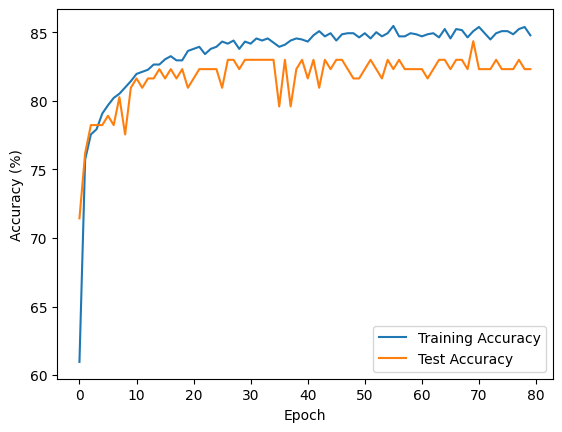

In [55]:
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Predict Weather on One Day

In [64]:
new_data = pd.DataFrame({
  'precipitation': [0.5],  # Example value
  'temp_max': [5],      # Example value
  'temp_min': [0],       # Example value
  'wind': [0]            # Example value
})

new_data[['precipitation', 'temp_max', 'temp_min', 'wind']] = scaler.transform(new_data[['precipitation', 'temp_max', 'temp_min', 'wind']])

prediction_data = torch.tensor(new_data.values, dtype=torch.float32)

output = model(prediction_data)
_, predicted = torch.max(output.data, 1)

weather_categories = list(weather_encoded.columns)
print(f'Predicted Weather: {weather_categories[predicted.item()][8:]}')

### if we found a suitable dataset that includes more recent weather, we might update result here

Predicted Weather: rain
